In [1]:
!pip install torch torchvision

In [2]:
!pip install pytorch-lightning numpy absl-py einops lightning-bolts typing opencv-python wandb scikit-learn matplotlib ml-collections
!pip install autopep8

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [3]:
!pip install --upgrade gdown

In [4]:
import os
import math
import cv2
import torch
import warnings
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch import einsum
from typing import Tuple
from functools import partial
from typing import Any, Callable
from einops import rearrange, repeat
from matplotlib import pyplot as plt
from einops.layers.torch import Rearrange
from einops.einops import reduce, rearrange
from pl_bolts.datamodules import MNISTDataModule
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchvision.transforms import Lambda, Compose, CenterCrop, RandAugment, AutoAugment, AutoAugmentPolicy, RandomCrop, RandomInvert, RandomPosterize, RandomSolarize, RandomResizedCrop, RandomAffine, GaussianBlur, RandomHorizontalFlip, Resize, RandomApply, ColorJitter, RandomGrayscale, RandomPerspective, RandomRotation, ToTensor, Normalize, RandomErasing, CenterCrop


/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [5]:
supervise = False
show_plot = True

# supervise = True
# show_plot = False

# patch_dim = 64
patch_dim = 128
# patch_size = 4
patch_size = 1

plot = 0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Utils
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

# Create two crops of the same image
class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

# head H1
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

class Siren(pl.LightningModule):
    def __init__(self):
        super(Siren, self).__init__()
    def forward(self,x):
        return torch.sin(x)

def plot_islands_agreement(levels, image):
    global plot
    plot += 1
    if plot % 500 == 0 :
        image_cpu = image.permute(1,2,0).detach().cpu().numpy()
        lin = nn.Linear(levels.shape[-1], 2).cuda()
        levels_2 = lin(levels)
        levels_2 = rearrange(levels_2,'(w h) l a -> w h l a', w = int(math.sqrt(levels.detach().cpu().numpy().shape[0])))
        levels_cpu_2 = levels_2.detach().cpu().numpy()

        mylevels = []
        for l in range(levels_cpu_2.shape[2]):
            mylevels.append(levels_cpu_2[:,:,l,:])

        fig, axs = plt.subplots(1, len(mylevels) + 1)
        plt.rcParams["figure.figsize"] = (25,3)
        axs[-1].imshow(image_cpu)
        axs[-1].set_box_aspect(1)
        axs[-1].grid(False)
        axs[-1].axes.xaxis.set_visible(False)
        axs[-1].axes.yaxis.set_visible(False)
        for i, matrice in enumerate(mylevels):
            x = np.arange(0.5, matrice.shape[0], 1)
            y = np.arange(0.5, matrice.shape[0], 1)
            xx, yy = np.meshgrid(x, y)
            r = np.power(np.add(np.power(matrice[:,:,0],2), np.power(matrice[:,:,1],2)),0.5)
            axs[i].imshow(r, cmap='inferno', interpolation='nearest')

            axs[i].set_box_aspect(1)
            axs[i].grid(False)
            axs[i].axes.xaxis.set_visible(False)
            axs[i].axes.yaxis.set_visible(False)

        plt.show()

In [7]:
!wandb disabled

W&B disabled.


In [8]:
# Model
TOKEN_ATTEND_SELF_VALUE = -5e-4

class ConvTokenizer(pl.LightningModule):
    def __init__(self, in_channels=3, embedding_dim=64):
        super(ConvTokenizer, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels,
                      embedding_dim // 2,
                      kernel_size=(3, 3),
                      stride=(2, 2),
                      padding=(1, 1),
                      bias=False),
            nn.BatchNorm2d(embedding_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(embedding_dim // 2,
                      embedding_dim // 2,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=(1, 1),
                      bias=False),
            nn.BatchNorm2d(embedding_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(embedding_dim // 2,
                      embedding_dim,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=(1, 1),
                      bias=False),
            nn.BatchNorm2d(embedding_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3),
                         stride=(2, 2),
                         padding=(1, 1),
                         dilation=(1, 1))
        )

    def forward(self, x):
        return self.block(x)

class ColumnNet(pl.LightningModule):
    def __init__(self, dim, groups, mult = 4, activation = nn.GELU):
        super().__init__()

        total_dim = dim * groups
        # conv_image_size=7
        num_patches = (7 // patch_size) ** 2

        self.net = nn.Sequential(
            Rearrange('b n l d -> b (l d) n'),
            nn.LayerNorm(num_patches),
            nn.Conv1d(total_dim, total_dim * mult, 1, groups = groups),
            activation(),
            nn.LayerNorm(num_patches),
            nn.Conv1d(total_dim * mult, total_dim, 1, groups = groups),
            Rearrange('b (l d) n -> b n l d', l = groups)
        )

    def forward(self, levels):
        levels = self.net(levels)
        return levels

class ConsensusAttention(pl.LightningModule):
    def __init__(self, num_patches_side, attend_self = True, local_consensus_radius = 0):
        super().__init__()
        self.attend_self = attend_self
        self.local_consensus_radius = local_consensus_radius

        if self.local_consensus_radius > 0:
            coors = torch.stack(torch.meshgrid(
                torch.arange(num_patches_side),
                torch.arange(num_patches_side)
            )).float()

            coors = rearrange(coors, 'c h w -> (h w) c')
            dist = torch.cdist(coors, coors)
            mask_non_local = dist > self.local_consensus_radius
            mask_non_local = rearrange(mask_non_local, 'i j -> () i j')
            self.register_buffer('non_local_mask', mask_non_local)

    def forward(self, levels):
        _, n, _, d, device = *levels.shape, levels.device
        q, k, v = levels, F.normalize(levels, dim = -1), levels

        sim = einsum('b i l d, b j l d -> b l i j', q, k) * (d ** -0.5)

        if not self.attend_self:
            self_mask = torch.eye(n, device = device, dtype = torch.bool)
            self_mask = rearrange(self_mask, 'i j -> () () i j')
            sim.masked_fill_(self_mask, TOKEN_ATTEND_SELF_VALUE)

        if self.local_consensus_radius > 0:
            max_neg_value = -torch.finfo(sim.dtype).max
            sim.masked_fill_(self.non_local_mask, max_neg_value)

        attn = sim.softmax(dim = -1)
        out = einsum('b l i j, b j l d -> b i l d', attn, levels)
        return out

class Agglomerator(pl.LightningModule):
    def __init__(self,
        *,
        consensus_self = False,
        local_consensus_radius = 0
        ):
        super(Agglomerator, self).__init__()

        # conv_image_size=7
        self.num_patches_side = (7 // patch_size)
        self.num_patches =  self.num_patches_side ** 2
        self.features = []
        self.labels = []
        # levels=2
        self.iters = default(None, 2 * 2)
        self.batch_acc = 0

        self.wl = torch.nn.parameter.Parameter(torch.tensor(0.25, device=self.device), requires_grad=True)
        self.wBU = torch.nn.parameter.Parameter(torch.tensor(0.25, device=self.device), requires_grad=True)
        self.wTD = torch.nn.parameter.Parameter(torch.tensor(0.25, device=self.device), requires_grad=True)
        self.wA = torch.nn.parameter.Parameter(torch.tensor(0.25, device=self.device), requires_grad=True)

        self.image_to_tokens = nn.Sequential(
            # n_channels=3
            ConvTokenizer(in_channels=3, embedding_dim=patch_dim // (patch_size ** 2)),
            Rearrange('b d (h p1) (w p2) -> b (h w) (d p1 p2)', p1 = patch_size, p2 = patch_size),
        )

        self.contrastive_head = nn.Sequential(
            nn.LayerNorm(patch_dim),
            # dropout=0.3
            nn.Dropout(p=0.3),
            Rearrange('b n d -> b (n d)'),
            nn.LayerNorm(self.num_patches * patch_dim),
            # dropout=0.3
            nn.Dropout(p=0.3),
            nn.Linear(self.num_patches * patch_dim, self.num_patches * patch_dim),
            nn.LayerNorm(self.num_patches * patch_dim),
            nn.GELU(),
            nn.LayerNorm(self.num_patches * patch_dim),
            # dropout=0.3
            nn.Dropout(p=0.3),
            # contr_dim=512
            nn.Linear(self.num_patches * patch_dim, 512)
        )

        self.classification_head_from_contr = nn.Sequential(
            # contr_dim=512
            # contr_dim=512
            nn.Linear(512, 512),
            nn.GELU(),
            # n_classes=10
            # contr_dim=512
            nn.Linear(512, 10)
        )
        # levels=2
        self.init_levels = nn.Parameter(torch.randn(2, patch_dim))
        # levels=2
        self.bottom_up = ColumnNet( dim = patch_dim, activation=nn.GELU, groups = 2)
        # levels=2
        self.top_down = ColumnNet( dim = patch_dim, activation=Siren, groups = 2 - 1)
        self.attention = ConsensusAttention(self.num_patches_side, attend_self = consensus_self, local_consensus_radius = local_consensus_radius)

    def forward(self, img, levels = None):
        b, device = img.shape[0], img.device

        tokens = self.image_to_tokens(img)
        n = tokens.shape[1]

        bottom_level = tokens
        bottom_level = rearrange(bottom_level, 'b n d -> b n () d')

        if not exists(levels):
            levels = repeat(self.init_levels, 'l d -> b n l d', b = b, n = n)

        hiddens = [levels]
        # levels=2
        num_contributions = torch.empty(2, device = device).fill_(4)
        num_contributions[-1] = 3

        # for _ in range(self.iters):
        for _ in range(4):
            levels_with_input = torch.cat((bottom_level, levels), dim = -2)

            bottom_up_out = self.bottom_up(levels_with_input[..., :-1, :])

            top_down_out = self.top_down(torch.flip(levels_with_input[..., 2:, :], [2]))
            top_down_out = F.pad(torch.flip(top_down_out, [2]), (0, 0, 0, 1), value = 0.)

            consensus = self.attention(levels)

            levels_sum = torch.stack((
                levels * self.wl, \
                bottom_up_out * self.wBU, \
                top_down_out * self.wTD, \
                consensus * self.wA
            )).sum(dim = 0)
            levels_mean = levels_sum / rearrange(num_contributions, 'l -> () () l ()')

            self.log('Weights/wl', self.wl)
            self.log('Weights/wBU', self.wBU)
            self.log('Weights/wTD', self.wTD)
            self.log('Weights/wA', self.wA)

            levels = levels_mean
            hiddens.append(levels)

        all_levels = torch.stack(hiddens)

        # denoise_iter=-1
        top_level = all_levels[-1, :, :, -1]

        top_level = self.contrastive_head(top_level)
        top_level = F.normalize(top_level, dim=1)

        return top_level, all_levels[-1,0,:,:,:]

    def training_step(self, train_batch, batch_idx):
        image = train_batch[0]
        label = train_batch[1]
        self.training_batch_idx = batch_idx

        if(not supervise):
            image = torch.cat([image[0], image[1]], dim=0)

        if(supervise):
            with torch.no_grad():
                top_level, _ = self.forward(image)
                self.features.append(list(top_level.data.cpu().numpy()))
                self.labels.append(label.cpu().numpy())
        else:
            top_level, toplot = self.forward(image)
            if(show_plot):
                plot_islands_agreement(toplot, image[0,:,:,:])

        if(supervise):
            output = self.classification_head_from_contr(top_level)
            loss = F.cross_entropy(output, label)
            self.batch_acc = self.accuracy(output.data,label,topk=(1,))[0]
            self.log('Training/accuracy', self.batch_acc, prog_bar=True, sync_dist=True)
            self.batch_acc = 0

        else:
            # batch_size=1024
            # num_gpus=1
            # batch_size=1024
            # num_gpus=1
            f1, f2 = torch.split(top_level, [1024 // 1, 1024 // 1], dim=0)
            output = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
            # temperature=0.07
            criterion = SupConLoss(temperature=0.07)
            loss = criterion(output, label)

        self.log('Training/loss', loss, sync_dist=True)
        self.log('Training/LR', self.optimizer.param_groups[0]['lr'], prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        image = val_batch[0]
        label = val_batch[1]
        self.val_batch_idx = batch_idx

        if(not supervise):
            image = torch.cat([image[0], image[1]], dim=0)

        if(supervise):
            with torch.no_grad():
                top_level, _ = self.forward(image)
                self.features.append(list(top_level.data.cpu().numpy()))
                self.labels.append(label.cpu().numpy())
        else:
            top_level, toplot = self.forward(image)
            # if(self.FLAGS.plot_islands):
            if(True):
                plot_islands_agreement(toplot, image[0,:,:,:])

        if(supervise):
            output = self.classification_head_from_contr(top_level)
            loss = F.cross_entropy(output, label)
            self.batch_acc = self.accuracy(output.data,label,topk=(1,))[0]
            self.log('Validation/accuracy', self.batch_acc, prog_bar=True, sync_dist=True)
            self.batch_acc = 0

        else:
            # batch_size=1024
            # num_gpus=1
            # batch_size=1024
            # num_gpus=1
            f1, f2 = torch.split(top_level, [1024 // 1, 1024 // 1], dim=0)
            output = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
            # temperature=0.07
            criterion = SupConLoss(temperature=0.07)
            loss = criterion(output, label)

        self.log('Validation/loss', loss, sync_dist=True)
        return loss

    def test_step(self, test_batch, batch_idx):
        image = test_batch[0]
        label = test_batch[1]
        self.test_batch_idx = batch_idx

        if(not supervise):
            image = torch.cat([image[0], image[1]], dim=0)

        if(supervise):
            with torch.no_grad():
                top_level, _ = self.forward(image)
                self.features.append(list(top_level.data.cpu().numpy()))
                self.labels.append(label.cpu().numpy())
        else:
            top_level, toplot = self.forward(image)
            if(show_plot):
                plot_islands_agreement(toplot, image[0,:,:,:])

        if(supervise):
            # head H2
            output = self.classification_head_from_contr(top_level)
            loss = F.cross_entropy(output, label)
            self.batch_acc = self.accuracy(output.data,label,topk=(1,))[0]
            self.log('Test/accuracy', self.batch_acc, prog_bar=True, sync_dist=True)
            self.batch_acc = 0

        else:
            # batch_size=1024
            # num_gpus=1
            # batch_size=1024
            # num_gpus=1
            f1, f2 = torch.split(top_level, [1024 // 1, 1024 // 1], dim=0)
            output = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
            # temperature=0.07
            criterion = SupConLoss(temperature=0.07)
            loss = criterion(output, label)


        self.log('Test/loss', loss, sync_dist=True)
        return loss

    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(
            self.parameters(),
            # learning_rate=0.05
            lr=0.05,
            # weight_decay=5e-4
            weight_decay=5e-4,
        )
        # batch_size=1024
        steps_per_epoch = 45000 // 1024
        scheduler_dict = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(
                self.optimizer,
                # learning_rate=0.05
                max_lr=0.05,
                epochs=2000,
                steps_per_epoch=steps_per_epoch,
            ),
            'interval': 'step',
        }
        return {'optimizer': self.optimizer, 'lr_scheduler': scheduler_dict}

    def accuracy(self, output, target, topk=(1,)):
        """Computes the precision@k for the specified values of k"""
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

# Train

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Total trainable parameters:  43370326


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                           | Type               | Params
----------------------------------------------------------------------
0 | image_to_tokens                | Sequential         | 112 K 
1 | contrastive_head               | Sequential         | 42.6 M
2 | classification_head_from_contr | Sequential         | 267 K 
3 | bottom_up                      | ColumnNet          | 263 K 
4 | top_down                       | ColumnNet          | 131 K 
5 | attention                      | ConsensusAttention | 0     
----------------------------------------------------------------------
43.4 M    Trainable params
0         Non-trainable params
43.4 M    Total params
173.481   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

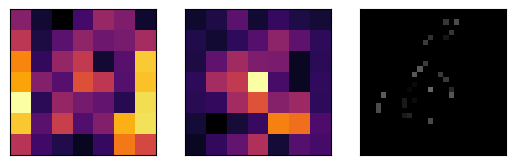

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

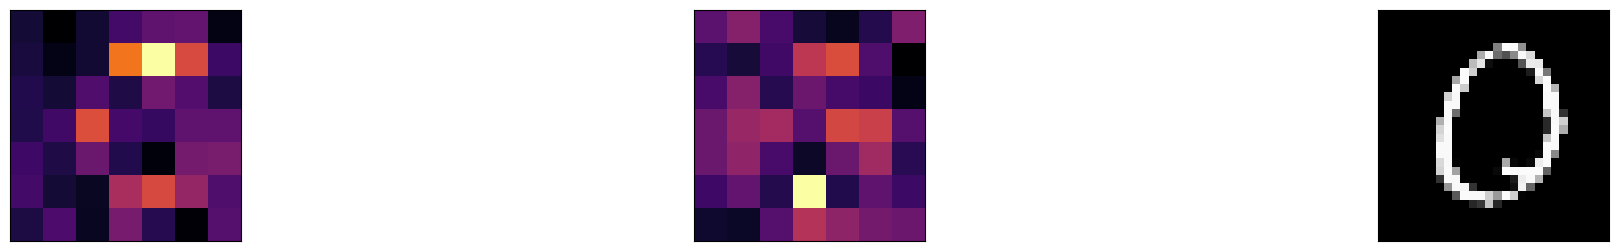

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

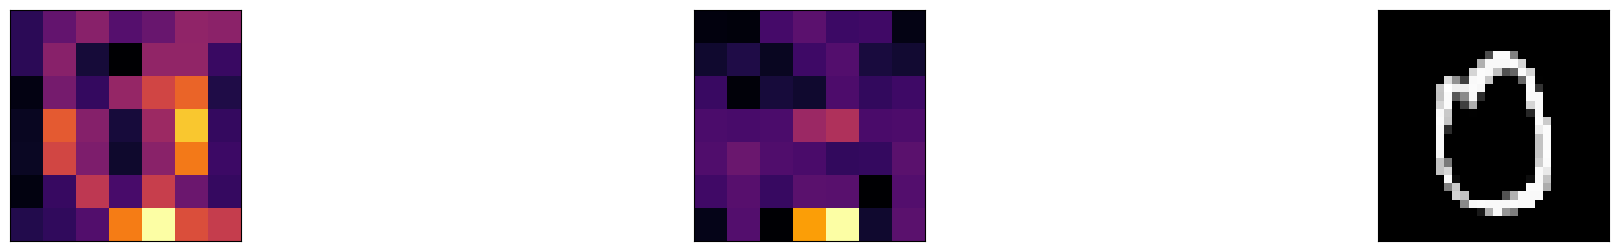

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

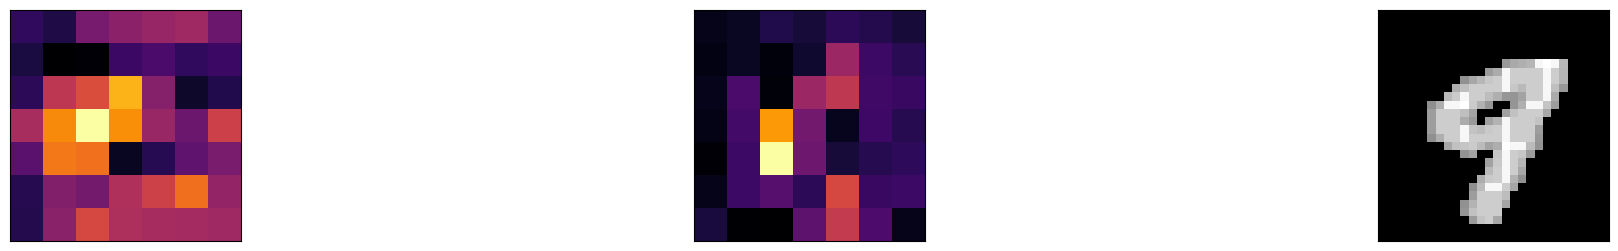

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

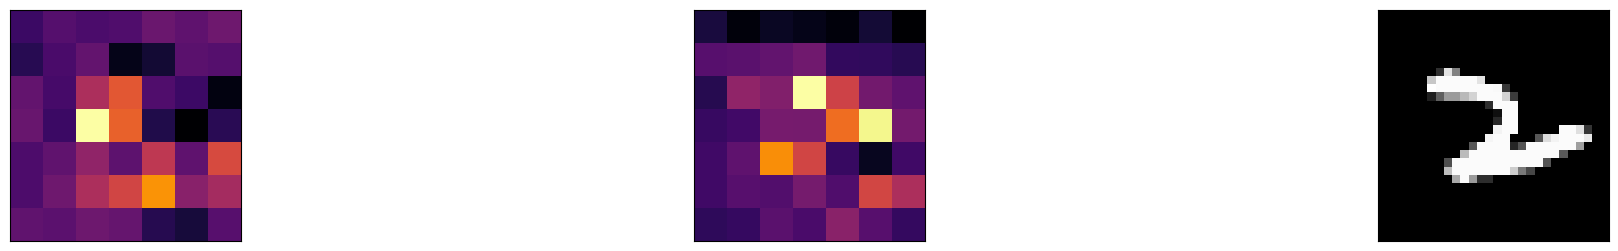

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [9]:
# Main
# mode=train
# on supervise

def init_all():
    warnings.filterwarnings("ignore")

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

    # seed=42
    pl.seed_everything(42)
    torch.cuda.empty_cache()


init_all()
# exp_name=MNIST
wandb_logger = WandbLogger(project="Agglomerator", name="MNIST")
# wandb_logger.experiment.config.update()

# dataset=MNIST
# MNISTDataModule
dm = MNISTDataModule(
    "./datasets",
     # batch_size=1024
    batch_size=1024,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

# from MNIST
train_transforms = Compose([
            RandAugment(),
            ToTensor(),
            Lambda(lambda x: x.repeat(3, 1, 1) ),
            Normalize((0.5,), (0.5,)),
        ])
test_transforms = Compose([
            ToTensor(),
            Lambda(lambda x: x.repeat(3, 1, 1) ),
            Normalize((0.5,), (0.5,))
        ])


# Apply trainsforms
if(supervise):
    dm.train_transforms = train_transforms
    dm.val_transforms = test_transforms
    dm.test_transforms = test_transforms
else:
    dm.train_transforms = TwoCropTransform(train_transforms)
    dm.val_transforms = TwoCropTransform(test_transforms)
    dm.test_transforms = TwoCropTransform(test_transforms)

model = Agglomerator()

# load_checkpoint_dir=path_to_checkpoint.ckpt
checkpoint_dir = os.path.join(os.getcwd(), "MNIST_contr.ckpt")

print("Total trainable parameters: ", count_parameters(model))

# mode=train
trainer = pl.Trainer(
    gpus=-1,
    strategy='dp',
    # max_epochs=50
    max_epochs=50,
    # limit_train=1.0
    limit_train_batches=1.0,
    # limit_val=1.0
    limit_val_batches=1.0,
    # limit_test=1.0
    limit_test_batches=1.0,
    logger=wandb_logger,
    reload_dataloaders_every_n_epochs = 1
)

trainer.fit(model, dm)


In [10]:
supervise = True
show_plot = False

In [12]:
# Main
# mode=train
# supervise

def init_all():
    warnings.filterwarnings("ignore")

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

    # seed=42
    pl.seed_everything(42)
    torch.cuda.empty_cache()


init_all()
# exp_name=MNIST
wandb_logger = WandbLogger(project="Agglomerator", name="MNIST")
# wandb_logger.experiment.config.update()

# dataset=MNIST
# MNISTDataModule
dm = MNISTDataModule(
    "./datasets",
     # batch_size=1024
    batch_size=1024,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

# from MNIST
train_transforms = Compose([
            RandAugment(),
            ToTensor(),
            Lambda(lambda x: x.repeat(3, 1, 1) ),
            Normalize((0.5,), (0.5,)),
        ])
test_transforms = Compose([
            ToTensor(),
            Lambda(lambda x: x.repeat(3, 1, 1) ),
            Normalize((0.5,), (0.5,))
        ])


# Apply trainsforms
if(supervise):
    dm.train_transforms = train_transforms
    dm.val_transforms = test_transforms
    dm.test_transforms = test_transforms
else:
    dm.train_transforms = TwoCropTransform(train_transforms)
    dm.val_transforms = TwoCropTransform(test_transforms)
    dm.test_transforms = TwoCropTransform(test_transforms)

model = Agglomerator()

# load_checkpoint_dir=path_to_checkpoint.ckpt
checkpoint_dir = os.path.join(os.getcwd(), "MNIST_contr.ckpt")

print("Total trainable parameters: ", count_parameters(model))

# mode=train
trainer = pl.Trainer(
    gpus=-1,
    strategy='dp',
    # max_epochs=5
    max_epochs=5,
    # limit_train=1.0
    limit_train_batches=1.0,
    # limit_val=1.0
    limit_val_batches=1.0,
    # limit_test=1.0
    limit_test_batches=1.0,
    logger=wandb_logger,
    reload_dataloaders_every_n_epochs = 1
)

# resume_training=False
model = model.load_from_checkpoint(checkpoint_dir, strict=False) if True else model

trainer.fit(model, dm)


INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Total trainable parameters:  43370326


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                           | Type               | Params
----------------------------------------------------------------------
0 | image_to_tokens                | Sequential         | 112 K 
1 | contrastive_head               | Sequential         | 42.6 M
2 | classification_head_from_contr | Sequential         | 267 K 
3 | bottom_up                      | ColumnNet          | 263 K 
4 | top_down                       | ColumnNet          | 131 K 
5 | attention                      | ConsensusAttention | 0     
----------------------------------------------------------------------
43.4 M    Trainable params
0         Non-trainable params
43.4 M    Total params
173.481   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


# Test

In [ ]:
# # Main
# # mode=Test

# def init_all():
#     torch.backends.cudnn.enabled = True
#     torch.backends.cudnn.benchmark = True

#     # torch.backends.cudnn.deterministic = True

#     # seed=42
#     pl.seed_everything(42)
#     torch.cuda.empty_cache()


# init_all()
# warnings.filterwarnings("ignore")
# # exp_name=MNIST
# wandb_logger = WandbLogger(project="Agglomerator", name="MNIST")
# # wandb_logger.experiment.config.update()

# # dataset=MNIST
# # MNISTDataModule
# dm = MNISTDataModule(
#     "./datasets",
#      # batch_size=1024
#     batch_size=1024,
#     shuffle=True,
#     pin_memory=True,
#     drop_last=True
# )

# # from MNIST
# train_transforms = Compose([
#             RandAugment(),
#             ToTensor(),
#             Lambda(lambda x: x.repeat(3, 1, 1) ),
#             Normalize((0.5,), (0.5,)),
#         ])
# test_transforms = Compose([
#             ToTensor(),
#             Lambda(lambda x: x.repeat(3, 1, 1) ),
#             Normalize((0.5,), (0.5,))
#         ])


# # Apply trainsforms
# if(supervise):
#     dm.train_transforms = train_transforms
#     dm.val_transforms = test_transforms
#     dm.test_transforms = test_transforms
# else:
#     dm.train_transforms = TwoCropTransform(train_transforms)
#     dm.val_transforms = TwoCropTransform(test_transforms)
#     dm.test_transforms = TwoCropTransform(test_transforms)

# model = Agglomerator()

# # load_checkpoint_dir=MNIST_contr.ckpt
# checkpoint_dir = os.path.join(os.getcwd(), "MNIST_contr.ckpt")

# print("Total trainable parameters: ", count_parameters(model))

# # mode=test

# model = model.load_from_checkpoint(checkpoint_dir, strict=False)
# model.configure_optimizers()

# dm.prepare_data()
# dm.setup()

# trainer = pl.Trainer(
#     gpus=-1,
#     strategy='dp',
#     resume_from_checkpoint=checkpoint_dir,
#     # max_epochs=10
#     max_epochs=10,
#     # limit_train=1.0
#     limit_train_batches=1.0,
#     # limit_val=1.0
#     limit_val_batches=1.0,
#     # limit_test=1.0
#     limit_test_batches=1.0
# )

# trainer.test(model, dataloaders=dm.test_dataloader())

# freeze

In [13]:
# Main
# mode=freeze

def init_all():

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

    # seed=42
    pl.seed_everything(42)
    torch.cuda.empty_cache()


init_all()
warnings.filterwarnings("ignore")
# exp_name=MNIST
wandb_logger = WandbLogger(project="Agglomerator", name="MNIST")
# wandb_logger.experiment.config.update()

# dataset=MNIST
# MNISTDataModule
dm = MNISTDataModule(
    "./datasets",
     # batch_size=1024
    batch_size=1024,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

# from MNIST
train_transforms = Compose([
            RandAugment(),
            ToTensor(),
            Lambda(lambda x: x.repeat(3, 1, 1) ),
            Normalize((0.5,), (0.5,)),
        ])
test_transforms = Compose([
            ToTensor(),
            Lambda(lambda x: x.repeat(3, 1, 1) ),
            Normalize((0.5,), (0.5,))
        ])


# Apply trainsforms
if(supervise):
    dm.train_transforms = train_transforms
    dm.val_transforms = test_transforms
    dm.test_transforms = test_transforms
else:
    dm.train_transforms = TwoCropTransform(train_transforms)
    dm.val_transforms = TwoCropTransform(test_transforms)
    dm.test_transforms = TwoCropTransform(test_transforms)

model = Agglomerator()

# load_checkpoint_dir=MNIST_contr.ckpt
checkpoint_dir = os.path.join(os.getcwd(), "MNIST_contr.ckpt")

print("Total trainable parameters: ", count_parameters(model))

# mode=freeze

datasplits = [dm.train_dataloader, dm.val_dataloader, dm.test_dataloader]
modes = ["Training", "Validation", "Test"]
features_names = ['/features_train', '/features_val', '/features_test']
labels_names = ['/labels_train', '/labels_val', '/labels_test']

for i, (d, m, f, l) in enumerate(zip(datasplits, modes, features_names, labels_names)):
    model = model.load_from_checkpoint(checkpoint_dir, strict=False)
    model.configure_optimizers()

    dm.prepare_data()
    dm.setup()

    trainer = pl.Trainer(
        gpus=-1,
        strategy='dp',
        resume_from_checkpoint=checkpoint_dir,
        # max_epochs=10
        max_epochs=10,
        # limit_train=1.0
        limit_train_batches=1.0,
        # limit_val=1.0
        limit_val_batches=1.0,
        # limit_test=1.0
        limit_test_batches=1.0
    )

    trainer.test(model, dataloaders=d())

model.batch_acc = 0

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Total trainable parameters:  43370326


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/accuracy       │     99.71764373779297     │
│         Test/loss         │   0.011816724203526974    │
│        Weights/wA         │    0.22308732569217682    │
│        Weights/wBU        │    0.37473729252815247    │
│        Weights/wTD        │    0.0957554504275322     │
│        Weights/wl         │    0.12277396023273468    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/accuracy       │         99.609375         │
│         Test/loss         │    0.02136811427772045    │
│        Weights/wA         │    0.22308732569217682    │
│        Weights/wBU        │    0.3747377097606659     │
│        Weights/wTD        │    0.09575540572404861    │
│        Weights/wl         │    0.1227736547589302     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/accuracy       │     99.65277862548828     │
│         Test/loss         │   0.015145432204008102    │
│        Weights/wA         │     0.223087340593338     │
│        Weights/wBU        │    0.3747377097606659     │
│        Weights/wTD        │    0.09575540572404861    │
│        Weights/wl         │    0.1227736622095108     │
└───────────────────────────┴───────────────────────────┘